### Preparing the data set and autocorrelation plots

In [2]:
# Data processing and functions
import pandas as pd
import numpy as np
import scipy as sp
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Analytics and modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.sandbox.tools.tools_pca as sm_pca
from statsmodels.formula.api import ols as sm_ols
from statsmodels.stats.anova import anova_lm as sm_anova
from patsy.contrasts import Treatment
from patsy import dmatrices
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR


from datetime import datetime
from datetime import timedelta
from pandas.core import datetools

# Graphing and visualizing
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from pylab import savefig

# Setting graphing preferences
sns.set(style="darkgrid", color_codes=True)

# Printing
import locale

# Show plots locally
locale.setlocale( locale.LC_ALL, '' )

%matplotlib inline

/home/benji/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
data = pd.read_csv(r'df_weather_scaled_encoded.csv')

In [4]:
data[0:3]

,datetime,city,temperature,humidity,pressure,wind_speed,wind_dir_E,wind_dir_N,wind_dir_NE,wind_dir_NW,...,wind_dir_SE,wind_dir_SW,wind_dir_W,weather_clear,weather_cloudy,weather_other,weather_partly_cloudy,weather_rain,weather_snow,weather_tstorm
0,2012-10-01 12:00:00,Portland,0.503824,0.800000,0.746667,0.0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2012-10-01 13:00:00,Portland,0.503824,0.800000,0.746667,0.0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2012-10-01 14:00:00,Portland,0.503865,0.789474,0.746667,0.0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [144]:
data.columns

# No nulls. checked

Index(['datetime', 'city', 'latitude', 'longitude', 'temperature', 'humidity',
       'pressure', 'wind_speed', 'wind_dir_E', 'wind_dir_N', 'wind_dir_NE',
       'wind_dir_NW', 'wind_dir_S', 'wind_dir_SE', 'wind_dir_SW', 'wind_dir_W',
       'weather_clear', 'weather_cloudy', 'weather_other',
       'weather_partly_cloudy', 'weather_rain', 'weather_snow',
       'weather_tstorm'],
      dtype='object')

In [5]:
data[['weather_clear', 'weather_cloudy', 'weather_other', 'weather_partly_cloudy', 'weather_rain', 'weather_snow',
    'weather_tstorm']] = data[['weather_clear', 'weather_cloudy', 'weather_other', 'weather_partly_cloudy', 'weather_rain', 
                               'weather_snow', 'weather_tstorm']].apply(pd.to_numeric, errors = 'coerce')

In [146]:
data['city'].unique()

array(['Portland', 'Seattle', 'Los Angeles', 'San Diego', 'Las Vegas',
       'Phoenix', 'Albuquerque', 'Denver', 'San Antonio', 'Dallas',
       'Houston', 'Kansas City', 'Minneapolis', 'Saint Louis', 'Chicago',
       'Nashville', 'Indianapolis', 'Atlanta', 'Detroit', 'Jacksonville',
       'Charlotte', 'Pittsburgh', 'Toronto', 'Philadelphia', 'Montreal',
       'Boston'], dtype=object)

In [7]:
data_charlotte = data[data['city'] == 'Charlotte']

In [8]:
data_charlotte.shape

(45253, 21)

In [29]:
data_charlotte_train = data_charlotte[data_charlotte['datetime'].astype(str).str[0:4].astype(int) < 2017]
data_charlotte_test = data_charlotte[data_charlotte['datetime'].astype(str).str[0:4].astype(int) == 2017]

In [30]:
data_charlotte_train.columns

Index(['datetime', 'city', 'temperature', 'humidity', 'pressure', 'wind_speed',
       'wind_dir_E', 'wind_dir_N', 'wind_dir_NE', 'wind_dir_NW', 'wind_dir_S',
       'wind_dir_SE', 'wind_dir_SW', 'wind_dir_W', 'weather_clear',
       'weather_cloudy', 'weather_other', 'weather_partly_cloudy',
       'weather_rain', 'weather_snow', 'weather_tstorm'],
      dtype='object')

In [31]:
X_train = data_charlotte_train
X_test = data_charlotte_test
y_train = data_charlotte_train['temperature']
y_test = data_charlotte_test['temperature']

In [32]:
lr = linear_model.LinearRegression()

lr.fit(pd.DataFrame(X_train[X_train.columns.difference(['datetime', 'city', 'latitude', 'longitude', 'temperature'])]), y_train)

y_fit = lr.predict(pd.DataFrame(X_train[X_train.columns.difference(['datetime', 'city', 'latitude', 'longitude', 'temperature'])]))

y_pred = lr.predict(pd.DataFrame(X_test[X_test.columns.difference(['datetime', 'city', 'latitude', 'longitude', 'temperature'])]))

#Performance on the test set

mse = mean_squared_error(y_pred, y_test)

print("Mean Square Error: %0.2f" % (mse))


Mean Square Error: 0.01


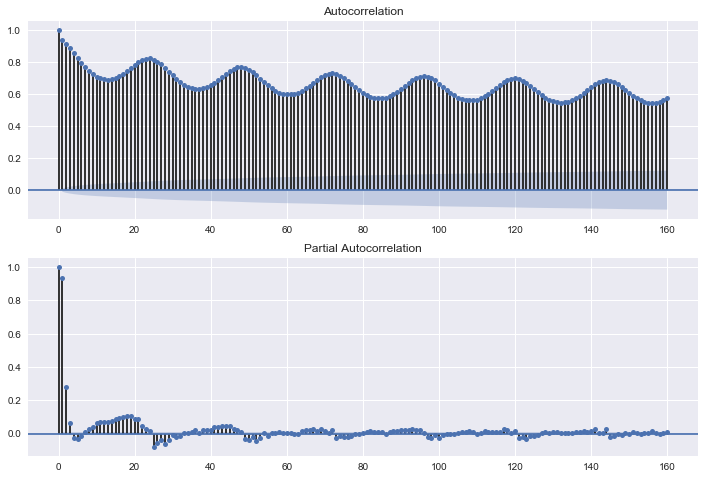

In [155]:
# Residual ACF, PACF

resid = y_train - y_fit

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid, lags=160, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=160, ax=ax2)

# The below plots demonstrate that there is certainly a 24 hour cycle to an extnent

### How does a plot of predicted vs actual look?

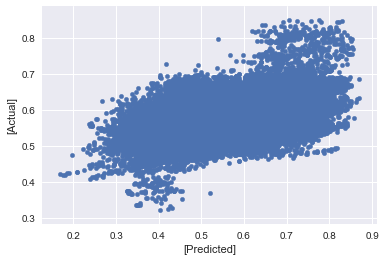

In [156]:
fit_train = pd.DataFrame(y_fit, y_train)
fit_train = fit_train.reset_index()
fit_train.columns = ['Predicted', 'Actual']
scatt = fit_train.plot(x = ['Predicted'], y = ['Actual'], kind = 'scatter')
plt.show()

In [12]:
data_charlotte_train['lag'] = data_charlotte_train['temperature'].shift(-4)
data_charlotte_train.dropna(inplace=True)
data_charlotte_train.index = data_charlotte_train['datetime']

/home/benji/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/benji/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### ARIMA models

#### Using just t-4, t-5 hour temperature data to predict t

In [14]:
model_2hr = sm.tsa.ARIMA(endog = data_charlotte_train['lag'],order=[2,1,0])
results_2hr = model_2hr.fit()
print(results_2hr.summary())

/home/benji/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/benji/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                             ARIMA Model Results                              
Dep. Variable:                  D.lag   No. Observations:                37251
Model:                 ARIMA(2, 1, 0)   Log Likelihood              102452.221
Method:                       css-mle   S.D. of innovations              0.015
Date:                Tue, 01 May 2018   AIC                        -204896.441
Time:                        09:34:12   BIC                        -204862.340
Sample:                    10-01-2012   HQIC                       -204885.611
                         - 12-31-2016                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2.845e-06      0.000     -0.016      0.988      -0.000       0.000
ar.L1.D.lag     0.2662      0.005     53.732      0.000       0.256       0.276
ar.L2.D.lag     0.2932      0.005     59.190    

In [15]:
(results_2hr.predict(start= len(data_charlotte_train), end = len(data_charlotte_train) + len(data_charlotte_test)))[0:3]

/home/benji/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


2016-12-31 20:00:00   -0.000845
2016-12-31 21:00:00   -0.001155
2016-12-31 22:00:00   -0.000556
Freq: H, dtype: float64

In [16]:
predictions_2hr = pd.DataFrame((results_2hr.predict(start= len(data_charlotte_train), end = len(data_charlotte_train) -1 + len(data_charlotte_test))))
predictions_2hr.columns = ['predicted_values']
predictions_2hr['ground_truth'] = data_charlotte_test['temperature']
predictions_2hr['predicted_denormalized'] = predictions_2hr['predicted_values']*(99.95 - 0.515) + 0.515
predictions_2hr['grountruth_denormalized'] = predictions_2hr['ground_truth']*(99.95 - 0.515) + 0.515
rmse_2h = sqrt(mean_squared_error(predictions_2hr['predicted_denormalized'], predictions_2hr['grountruth_denormalized']))
print(rmse_2h)

/home/benji/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

#### Predicting Temperature at time T + 4 by looking at temperatures between T and T - 24

In [170]:
model_24hr = sm.tsa.ARIMA(endog = data_charlotte_train['lag'],order=[24,1,0])
results_24hr = model_24hr.fit()
print(results_24hr.summary())

C:\Users\Prasanth\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.lag   No. Observations:                37247
Model:                ARIMA(24, 1, 0)   Log Likelihood              109788.653
Method:                       css-mle   S.D. of innovations              0.013
Date:                Mon, 30 Apr 2018   AIC                        -219525.305
Time:                        22:41:26   BIC                        -219303.647
Sample:                    10-02-2012   HQIC                       -219454.908
                         - 12-31-2016                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -4.9e-06   5.93e-05     -0.083      0.934      -0.000       0.000
ar.L1.D.lag      0.0428      0.005      8.871      0.000       0.033       0.052
ar.L2.D.lag      0.1328      0.005     27.52

In [276]:
predictions_24hr = pd.DataFrame((results_24hr.predict(start= len(data_charlotte_train), end = len(data_charlotte_train) -1 + len(data_charlotte_test))))
predictions_24hr.columns = ['predicted_values']
predictions_24hr['ground_truth'] = data_charlotte_test['temperature']
predictions_24hr['predicted_denormalized'] = predictions_24hr['predicted_values']*(99.95 - 0.515) + 0.515
predictions_24hr['grountruth_denormalized'] = predictions_24hr['ground_truth']*(99.95 - 0.515) + 0.515
rmse_24h = sqrt(mean_squared_error(predictions_24hr['predicted_denormalized'], predictions_24hr['grountruth_denormalized']))
print(rmse_24h)

61.580500717819284


#### Predicting Temperature at time T + 4 by looking at temperatures between T and T - 72

In [ ]:
model_24hr = sm.tsa.ARIMA(endog = data_charlotte_train['lag'],order=[72,1,0])
results_72hr = model_72hr.fit()
print(results_72hr.summary())

In [ ]:
predictions_72hr = pd.DataFrame((results_72hr.predict(start= len(data_charlotte_train), end = len(data_charlotte_train) -1 + len(data_charlotte_test))))
predictions_72hr.columns = ['predicted_values']
predictions_72hr['ground_truth'] = data_charlotte_test['temperature']
predictions_72hr['predicted_denormalized'] = predictions_72hr['predicted_values']*(99.95 - 0.515) + 0.515
predictions_72hr['grountruth_denormalized'] = predictions_72hr['ground_truth']*(99.95 - 0.515) + 0.515
rmse_72h = sqrt(mean_squared_error(predictions_72hr['predicted_denormalized'], predictions_72hr['grountruth_denormalized']))
print(rmse_72h)

### Few other standard modeling techniques: Regression, Random Forest and ANN

#### A little bit of data prep

In [346]:
data = pd.read_csv(r'C:\Users\Prasanth\Downloads\M.S. Data Science Academics\2nd Sem\Machine Learning\Projects\Final Project\df_weather_scaled_encoded.csv')
data_charlotte = data[data['city'] == 'Charlotte']
data_charlotte['temp_after_4hr'] = data_charlotte['temperature'].shift(-4)
data_charlotte['temp_avg_last_2hr'] = pd.rolling_mean(data_charlotte['temperature'], 2)
data_charlotte['temp_before_24hr'] = data_charlotte['temperature'].shift(24)
data_charlotte['temp_before_24hr_3day_avg'] = (data_charlotte['temperature'].shift(24) + data_charlotte['temperature'].shift(48)
                                               + data_charlotte['temperature'].shift(72))/3

C:\Users\Prasanth\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Prasanth\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=2,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Prasanth\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  T

In [347]:
data_charlotte = data_charlotte.dropna()
data_charlotte_train2 = data_charlotte[data_charlotte['datetime'].astype(str).str[0:4].astype(int) < 2017]
data_charlotte_test2 = data_charlotte[data_charlotte['datetime'].astype(str).str[0:4].astype(int) == 2017]

#### Modeling

In [348]:
response = np.ravel(data_charlotte_train2['temp_after_4hr'])
train = pd.DataFrame(data_charlotte_train2[data_charlotte_train2.columns.difference(['datetime', 'city', 'latitude', 'longitude', 'temp_after_4hr'])])
ground_truth = data_charlotte_test2['temp_after_4hr']
test = pd.DataFrame(data_charlotte_test2[data_charlotte_test2.columns.difference(['datetime', 'city', 'latitude', 'longitude', 'temp_after_4hr'])])
    
predicted_linear = LinearRegression().fit(train, response).predict(test)
predicted_rf = RandomForestRegressor().fit(train, response).predict(test)

# Neural network part

y_train = list(data_charlotte_train2['temp_after_4hr'])
X_train = pd.DataFrame(data_charlotte_train2[data_charlotte_train2.columns.difference(['datetime', 'city', 'latitude', 'longitude', 'temp_after_4hr'])])
y_test = list(data_charlotte_test2['temp_after_4hr'])
X_test = pd.DataFrame(data_charlotte_test2[data_charlotte_test2.columns.difference(['datetime', 'city', 'latitude', 'longitude', 'temp_after_4hr'])])

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
mlp = MLPRegressor(hidden_layer_sizes=(20,20,20),max_iter=500000)
mlp.fit(X_train,y_train)

predicted_neural = mlp.predict(X_test)

In [349]:
predictions_linear = pd.DataFrame(predicted_linear)
predictions_linear.columns = ['predicted_values']
predictions_linear['ground_truth'] = list(data_charlotte_test2['temp_after_4hr'])
predictions_linear['predicted_denormalized'] = predictions_linear['predicted_values']*(99.95 - 0.515) + 0.515
predictions_linear['grountruth_denormalized'] = predictions_linear['ground_truth']*(99.95 - 0.515) + 0.515
rmse_linear = sqrt(mean_squared_error(predictions_linear['predicted_denormalized'], predictions_linear['grountruth_denormalized']))
print(rmse_linear)

3.8720537516917335


In [351]:
predictions_rf = pd.DataFrame(predicted_rf)
predictions_rf.columns = ['predicted_values']
predictions_rf['ground_truth'] = list(data_charlotte_test2['temp_after_4hr'])
predictions_rf['predicted_denormalized'] = predictions_rf['predicted_values']*(99.95 - 0.515) + 0.515
predictions_rf['grountruth_denormalized'] = predictions_rf['ground_truth']*(99.95 - 0.515) + 0.515
rmse_rf = sqrt(mean_squared_error(predictions_rf['predicted_denormalized'], predictions_rf['grountruth_denormalized']))
print(rmse_rf)

3.90675088667548


In [352]:
predictions_neural = pd.DataFrame(predicted_neural)
predictions_neural.columns = ['predicted_values']
predictions_neural['ground_truth'] = list(data_charlotte_test2['temp_after_4hr'])
predictions_neural['predicted_denormalized'] = predictions_neural['predicted_values']*(99.95 - 0.515) + 0.515
predictions_neural['grountruth_denormalized'] = predictions_neural['ground_truth']*(99.95 - 0.515) + 0.515
rmse_neural = sqrt(mean_squared_error(predictions_neural['predicted_denormalized'], predictions_neural['grountruth_denormalized']))
print(rmse_neural)

5.403473607236868
